In [1]:
from sklearn.datasets import make_classification
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import random
import time



/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
#User input for algorithm:
#for synthetic data/potentially for regular datasets user can set the total subgroups/centroids
centroids = input("Enter number of centroids: ")
groups = input("Enter number of groups: ")

Enter number of centroids: 10
Enter number of groups: 6


In [3]:
#calculates euclidean distance between points
def calc_dist(x,y,x_ref,y_ref):
  return np.sqrt((((x-x_ref)**2)+((y-y_ref)**2))) 


In [4]:
#calculuates loss by inputting euclidean distance into sigmoid function
def calc_loss(x,y,x_ref,y_ref):
    # calculate Euclidean distance btw person & centroid
    distance = calc_dist(x,y,x_ref,y_ref)
    # refer to the above distance function to determine individual loss
    loss = 1/(1+ np.exp(-1*distance)) #converts distances to probability distribution
    #return loss
    return loss

In [5]:
#this function calculates the summation of all the individual losses within each cluster for minimizing the objective function
def sum_loss(df, centroids, subgroup_loss):
  #total datapoints
  tot_len = 0
  #sum of all individual losses between clusters
  loss_sum = 0
  clusters = []
  max_val = df['min_loss'].max()
  min_val = df['min_loss'].min()
  print('max ', max_val)
  print('min ', min_val)

  for i in centroids.keys():
    temp = df[df['min_centr']==i]
    temp = temp.reset_index()
    clusters.append(temp)
    tot_len += len(temp)
    loss_sum += temp['min_loss'].sum()
  tot_loss = (loss_sum/tot_len)*.1
  subgroup_loss = subgroup_loss *.1
  tot_loss += subgroup_loss
  print('indiv loss ', tot_loss)
  return tot_loss


In [6]:
def assign_cluster(df, centroids):
  k = 3
  start = time.time()
  for i in centroids.keys():
    #loss based on euclidean distance for each individual point compared to both centroids
    #stored in dataframe
    df['loss_from_{}'.format(i)] = calc_loss(df['x_coord'], df['y_coord'], centroids[i][0], centroids[i][1])
    df['dist_from_{}'.format(i)] = calc_dist(df['x_coord'], df['y_coord'], centroids[i][0], centroids[i][1])

  centroid_dist_col = ['loss_from_{}'.format(i) for i in centroids.keys()]
  distance = ['dist_from_{}'.format(i) for i in centroids.keys()]

  temp = pd.DataFrame(df, columns=distance)
  temp = temp.apply(np.sort, axis=1)
  count = 0
  for row in temp:
    temp[count] = row[:3]
    count+=1


  for i in range(k):
    df['min_{}_dist'.format(k)] = temp
  
  count = 0
  temp = pd.DataFrame(df, columns=centroid_dist_col)
  temp = temp.apply(np.sort, axis=1)
  count = 0
  for row in temp:
    temp[count] = row[:3]
    count+=1

  for i in range(k):
    df['min_{}_loss'.format(k)] = temp

  #df column which holds the value of the closest centroid for each point
  df['min_centr'] = df.loc[:, centroid_dist_col].idxmin(axis=1)
  df['min_centr'] = df['min_centr'].map(lambda x: int(x.lstrip('loss_from_')))
  #value of loss calculated from sigmoid in calc_loss function for individual loss
  df['min_loss'] = df[['loss_from_{}'.format(i) for i in centroids.keys()]].min(axis=1)
  end = time.time()
  print('Time elapsed Assignment Step: ', end - start)


  # for i in range(len(centroids)):
  #   # del df['loss_from_{}'.format(i)]
  #   lst = df['min_centr'].unique()
  #   if i not in lst:
  #     del df['dist_from_{}'.format(i)]
  # print(top_k)
  return df

In [7]:
# df = assign_cluster(df, centroids)
# df.head(3)

In [8]:
# # calculate subgroup loss for all groups
# k=3
# groups = compute_groups(df)
# subgroup_loss = []
# tot = 0
# lst = []
# for group in groups:
#   lst=[]
#   for i in range(k):
#     tot = 0
#     for row in group['min_{}_loss'.format(k)]:
#       tot += row[i]
#     lst.append(tot/len(group))
#   subgroup_loss.append(lst)


In [9]:
# subgroup_loss

In [10]:
# this function compares the loss between two groups at a certain percentile level
def compare_loss(group1,group2,percentile):
    select_group = [group1, group2]
    percentile_loss = []
    for s in select_group:
        s.sort_values(by=['min_loss'])
        subgroup = [s['min_loss']] # subset the two different groups of interest
        loss_p = stats.scoreatpercentile(subgroup, percentile) # find the level of loss at given percentile
        percentile_loss.append(loss_p) # load list with loss    
    difference = percentile_loss[0]-percentile_loss[1] # find difference between two @ percentile
    return np.abs(difference)

In [11]:
#calculates gradient for clusters
def update_weights(clust, lr, centr, df):
  #total number of points in cluster 0 (points nearest to centroid 0)
  #updated centroid coordinates 
  new_centr_x, new_centr_y = centr[0], centr[1]
  #calculate partial derivatives of euclidean distance functions
  x = clust['x_coord']
  y = clust['y_coord']
  center = clust['min_centr']
  distance = clust['dist_from_{}'.format(int(center))]
  grad_x = (centr[0]-x/distance)
  grad_y = (centr[1]-y/distance)
  new_centr_x -= (grad_x) * lr
  new_centr_y -= (grad_y) * lr
  return (new_centr_x, new_centr_y)

In [12]:
def mini_batch(df, b, count, temp_centroids, centroids):
  samp = df.sample(n=b, random_state=1)
  samp = samp.reset_index()
  start = time.time()
  for i in centroids.keys():
    count[i] = 0
  for s in range(len(samp)):
    clust = samp.iloc[s]['min_centr']
    clust = int(clust)
    count[clust]+=1
    lr = 1/count[clust]
    # temp = update_weights(samp.iloc[s], lr, temp_centroids[clust], df)
    temp_x = (1-lr)* centroids[clust][0] + lr* samp.iloc[s]['x_coord']
    temp_y = (1-lr)* centroids[clust][1] + lr* samp.iloc[s]['y_coord']
    temp_centroids[clust] = (temp_x, temp_y)
  end = time.time()
  print('Time elapsed Batch Step: ', end - start)
  return temp_centroids

In [13]:
#updates centroid locations based on gradient descent and loss constraint
def update(perc, centroids, df, subgroup_loss, loss):
  tot_loss_lst = []
  b = 32
  max_iter = 50
  iter_num = 0
  conv = 3
  j = 0
  tot_loss_lst.append(loss)
  L = perc * subgroup_loss
  print('L: ', L)
  #set temporary centroids for assignment
  temp_centroids = {}
  for i in centroids.keys():
    temp_centroids[i] = centroids[i]
  count = {}
  #beginning of updating 
  # while subgroup_loss > L and iter_num < max_iter:
  while iter_num < max_iter:
    start = time.time()
    old_loss = loss
    #set up for mini batch gradient descent
    temp_centroids = mini_batch(df, b, count, temp_centroids, centroids)
    #testing to see if new centroid locations improve summation of individual loss
    temp_df = assign_cluster(df, temp_centroids)
    groups = compute_groups(temp_df)
    cdf1, cdf2 = compute_cdf(groups)
    temp_subgroup_loss = compare_loss(groups[cdf1], groups[cdf2], 50)   
    temp_loss = sum_loss(temp_df, temp_centroids, temp_subgroup_loss)
    iter_num += 1
    print('iteration number: ', iter_num)
    print('old loss: ', old_loss)
    print('temp loss: ', temp_loss)
    if old_loss != temp_loss and j < conv:
      #only change centroid locations if it improves subgroup loss
      if old_loss > temp_loss:
        subgroup_loss = temp_subgroup_loss
        loss = temp_loss
        groups = compute_groups(temp_df)
        compute_cdf_graph(groups)
        for i in centroids.keys():
          centroids[i] = temp_centroids[i]
      else:
        j += 1
      print('subgroup loss: ', subgroup_loss)
      # loss = sum_loss(temp_df, centroids, subgroup_loss)
      tot_loss_lst.append(loss)
    else:
      end = time.time()
      print('Time elapsed End of Update Step: ', end - start)
      plt.title('Cost per iteration')
      plt.plot(tot_loss_lst)
      plt.show()
      return centroids
  plt.title('Cost per iteration')
  plt.plot(tot_loss_lst)
  plt.show()
  print('Reached max iterations')
  return centroids    

In [14]:
def compute_cdf(groups):
  lst = []
  perc = []
  for group in groups:
    sorted_data = group.sort_values(by=['min_loss'])
    sorted_len = len(sorted_data['min_loss'])
    yvals = np.arange(sorted_len)/float(sorted_len-1)
    lst.append(sorted_data['min_loss'].sum())
    subgroup = [sorted_data['min_loss']] # subset the two different groups of interest
    perc.append(stats.scoreatpercentile(subgroup, 50))
  min_ind = perc.index(min(perc))
  max_ind = perc.index(max(perc))
  return (max_ind, min_ind)

In [15]:
def compute_cdf_graph(groups):
  for group in groups:
    sorted_data = group.sort_values(by=['min_loss'])
    sorted_len = len(sorted_data['min_loss'])
    yvals = np.arange(sorted_len)/float(sorted_len-1)
    subgroup = [sorted_data['min_loss']] # subset the two different groups of interest
    plt.plot(sorted_data['min_loss'], yvals)
  plt.xlabel('loss per individual')
  plt.ylabel('% of people within certain loss of centroid')
  plt.title('Individual loss- CDF stratified by group')
  plt.show()

In [16]:
def compute_groups(df):
  num_groups = df.group.nunique()
  groups = []
  for i in range(num_groups):
    group = df[df['group']==i]
    group = group.reset_index()
    groups.append(group)
  return groups

In [17]:
def compute_clusters(df):
  num_clusters = df.min_centr.nunique()
  clusters = []
  for i in range(num_clusters):
    cluster = df[df['min_centr']==i]
    cluster = cluster.reset_index()
    clusters.append(cluster)
  return clusters

Time elapsed Assignment Step:  123.23262238502502


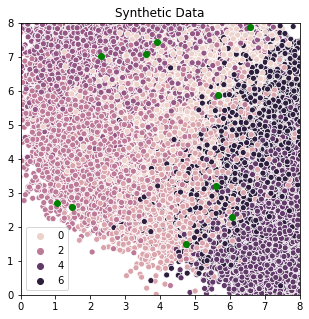

{0: (4.74269069668293, 1.4912991082753229),
 1: (5.66849933844808, 5.890491858505095),
 2: (6.56724580119343, 7.876107483873396),
 3: (5.589731038220875, 3.1894778778341744),
 4: (3.9180149826887236, 7.446848251239961),
 5: (1.039752618173151, 2.6889185850848962),
 6: (6.061814186699897, 2.280362605442922),
 7: (3.5898411154316157, 7.085084375073627),
 8: (1.4693059749333068, 2.596386756567654),
 9: (2.3057104722501855, 7.014154088532152)}

In [18]:
from sklearn.datasets import make_blobs


# Generate Imbalanced Synthetic Data
# X,y = make_classification(n_samples=500, n_classes=3,shift=4 ,n_informative=4, n_redundant=0, n_repeated=0, n_clusters_per_class=2,class_sep=.8,flip_y=0,weights=[0.80,.1,.1], random_state=55)
center_box = (0,8)
X, y = make_blobs(n_samples=800000, centers=int(groups), n_features=2,center_box=center_box,random_state=0)
# create dataframe to hold x and y coordinates
df = pd.DataFrame({
    'x_coord': X[:,0],
    'y_coord': X[:,1]})
df['group'] = y


#arbitrarily picked random k (number of centroids)
k = int(centroids)
centroids = {}
#randomly initialized centroid x and y coordinates (in real data we will actually have these coordinates)
for i in range(k):
  centroids[i] = ((random.uniform(1,8)), (random.uniform(1,8)))
#colors for centroids
color_map = {}
for i in range(k):
  color_map[i] = 'g'

#plot synthetic data
fig = plt.figure(figsize=(5,5))
ax = sns.scatterplot(X[:,0],X[:,1],hue=y)

for i in centroids.keys():
  plt.scatter(centroids[i][0], centroids[i][1], color=color_map[i])
df = assign_cluster(df, centroids)
df
plt.xlim(0, 8)
plt.ylim(0, 8)
ax.set_title("Synthetic Data")
plt.show()

centroids

Time elapsed Assignment Step:  126.21607685089111


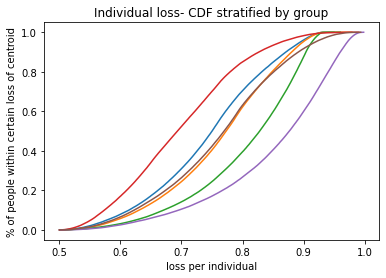

max  0.9983106290904792
min  0.5001175783476548
indiv loss  0.5672254381468964
L:  0.1282124140118127
Time elapsed Batch Step:  0.017899036407470703
Time elapsed Assignment Step:  123.7255425453186
max  0.9980061644861137
min  0.5
indiv loss  0.5388289553942098
iteration number:  1
old loss:  0.5672254381468964
temp loss:  0.5388289553942098


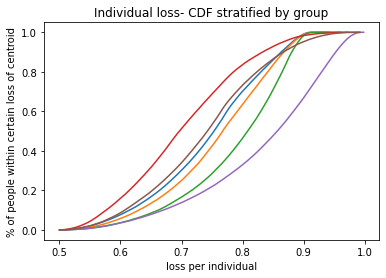

subgroup loss:  0.15999732627678243
Time elapsed Batch Step:  0.017583131790161133
Time elapsed Assignment Step:  123.96769309043884
max  0.997743583064829
min  0.5
indiv loss  0.5148212896043615
iteration number:  2
old loss:  0.5388289553942098
temp loss:  0.5148212896043615


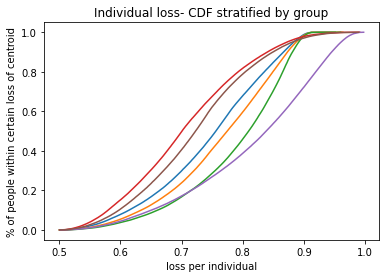

subgroup loss:  0.13770833199808485
Time elapsed Batch Step:  0.017923831939697266
Time elapsed Assignment Step:  124.37512946128845
max  0.9972651145537724
min  0.5
indiv loss  0.49253304483674964
iteration number:  3
old loss:  0.5148212896043615
temp loss:  0.49253304483674964


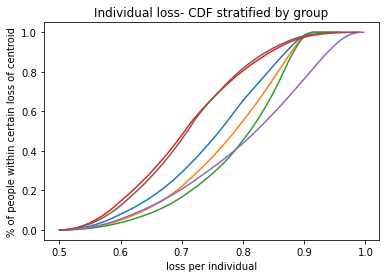

subgroup loss:  0.1164274546961096
Time elapsed Batch Step:  0.017798900604248047
Time elapsed Assignment Step:  122.96674752235413
max  0.9966537651393385
min  0.5
indiv loss  0.4855156928445764
iteration number:  4
old loss:  0.49253304483674964
temp loss:  0.4855156928445764


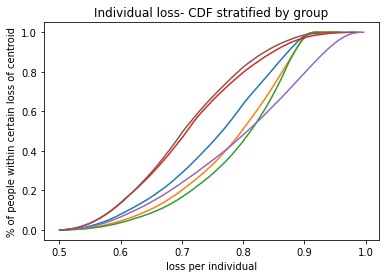

subgroup loss:  0.11005393731117075
Time elapsed Batch Step:  0.018224239349365234
Time elapsed Assignment Step:  121.86816334724426
max  0.9961128809103428
min  0.5
indiv loss  0.48736503050916863
iteration number:  5
old loss:  0.4855156928445764
temp loss:  0.48736503050916863
subgroup loss:  0.11005393731117075
Time elapsed Batch Step:  0.017393827438354492
Time elapsed Assignment Step:  123.49826002120972
max  0.9959150487433197
min  0.5
indiv loss  0.4809716776557974
iteration number:  6
old loss:  0.4855156928445764
temp loss:  0.4809716776557974


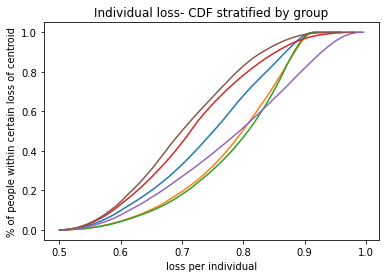

subgroup loss:  0.1079788858540004
Time elapsed Batch Step:  0.018349885940551758
Time elapsed Assignment Step:  123.24514269828796
max  0.9948986073261629
min  0.5
indiv loss  0.467757099955738
iteration number:  7
old loss:  0.4809716776557974
temp loss:  0.467757099955738


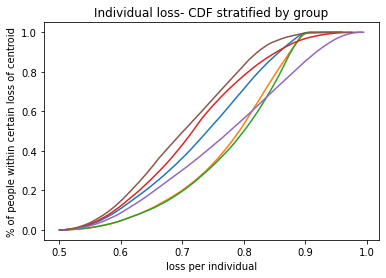

subgroup loss:  0.09835920251089048
Time elapsed Batch Step:  0.01740407943725586
Time elapsed Assignment Step:  122.28898000717163
max  0.9948714756569587
min  0.5
indiv loss  0.45675693420773217
iteration number:  8
old loss:  0.467757099955738
temp loss:  0.45675693420773217


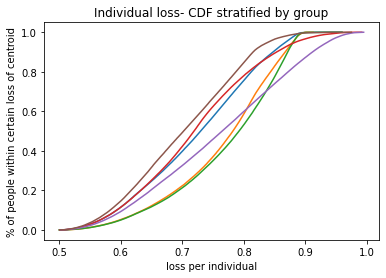

subgroup loss:  0.09016100755683076
Time elapsed Batch Step:  0.01936483383178711
Time elapsed Assignment Step:  123.4055666923523
max  0.9948451741262652
min  0.5
indiv loss  0.4502652603310041
iteration number:  9
old loss:  0.45675693420773217
temp loss:  0.4502652603310041


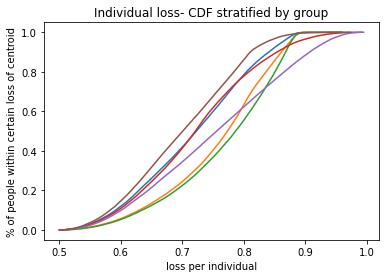

subgroup loss:  0.08560942072629107
Time elapsed Batch Step:  0.017646074295043945
Time elapsed Assignment Step:  123.75224113464355
max  0.9948281093843078
min  0.5
indiv loss  0.4453258033267497
iteration number:  10
old loss:  0.4502652603310041
temp loss:  0.4453258033267497


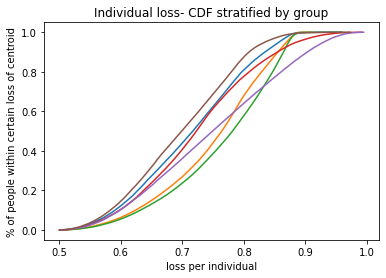

subgroup loss:  0.08247491799429174
Time elapsed Batch Step:  0.021605730056762695
Time elapsed Assignment Step:  122.05300569534302
max  0.9948169445099048
min  0.5
indiv loss  0.44191183458452604
iteration number:  11
old loss:  0.4453258033267497
temp loss:  0.44191183458452604


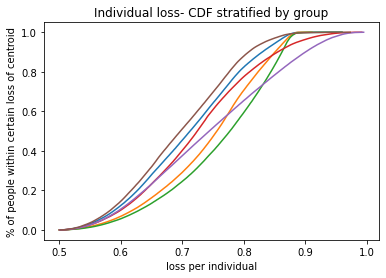

subgroup loss:  0.08040860937428418
Time elapsed Batch Step:  0.01804208755493164
Time elapsed Assignment Step:  122.08812141418457
max  0.9948095961599326
min  0.5
indiv loss  0.439623044259196
iteration number:  12
old loss:  0.44191183458452604
temp loss:  0.439623044259196


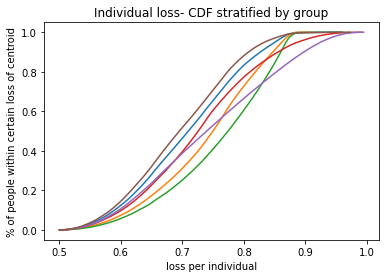

subgroup loss:  0.07911767878169951
Time elapsed Batch Step:  0.019275903701782227
Time elapsed Assignment Step:  123.11578583717346
max  0.9948047396854146
min  0.5
indiv loss  0.43798830589885696
iteration number:  13
old loss:  0.439623044259196
temp loss:  0.43798830589885696


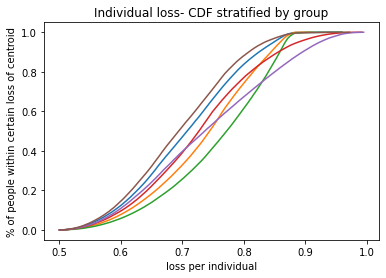

subgroup loss:  0.07822034806356193
Time elapsed Batch Step:  0.025313854217529297
Time elapsed Assignment Step:  122.63158369064331
max  0.9948015209643586
min  0.5
indiv loss  0.43674657474272427
iteration number:  14
old loss:  0.43798830589885696
temp loss:  0.43674657474272427


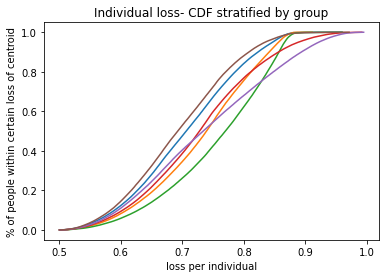

subgroup loss:  0.0776342377449416
Time elapsed Batch Step:  0.017394542694091797
Time elapsed Assignment Step:  122.83958911895752
max  0.9947993835845157
min  0.5
indiv loss  0.4380768737064115
iteration number:  15
old loss:  0.43674657474272427
temp loss:  0.4380768737064115
subgroup loss:  0.0776342377449416
Time elapsed Batch Step:  0.017447948455810547
Time elapsed Assignment Step:  123.38171172142029
max  0.9947993835845157
min  0.5
indiv loss  0.4380768737064115
iteration number:  16
old loss:  0.43674657474272427
temp loss:  0.4380768737064115
subgroup loss:  0.0776342377449416
Time elapsed Batch Step:  0.017817974090576172
Time elapsed Assignment Step:  124.108962059021
max  0.9947993835845157
min  0.5
indiv loss  0.4380768737064115
iteration number:  17
old loss:  0.43674657474272427
temp loss:  0.4380768737064115
Time elapsed End of Update Step:  126.72934031486511


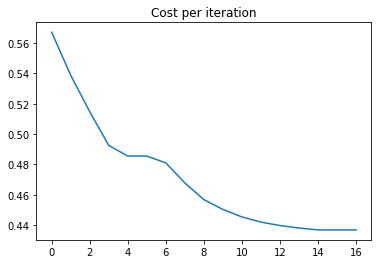

{0: (4.74269069668293, 1.4912991082753229),
 1: (7.485143008425895, 4.105431195341938),
 2: (6.56724580119343, 7.876107483873396),
 3: (6.147519019971428, 3.6173520073603056),
 4: (4.880942806242832, 5.505199221439369),
 5: (1.039752618173151, 2.6889185850848962),
 6: (6.620390567681479, 2.7218489166991198),
 7: (4.2126966472170935, 6.7245863199892835),
 8: (2.202694615123849, 2.994083378713736),
 9: (2.0626049383066962, 6.805547115104531)}

In [19]:
df = assign_cluster(df, centroids)
groups = compute_groups(df)
compute_cdf_graph(groups)
clusters = compute_clusters(df)
cdf1, cdf2 = compute_cdf(groups)
#subgroup loss between max and min loss
subgroup_loss = compare_loss(groups[cdf1], groups[cdf2], 50)
loss = sum_loss(df, centroids, subgroup_loss)
update(.7, centroids,df, subgroup_loss, loss)

In [20]:
df.head(3)

,x_coord,y_coord,group,loss_from_0,dist_from_0,loss_from_1,dist_from_1,loss_from_2,dist_from_2,loss_from_3,dist_from_3,loss_from_4,dist_from_4,loss_from_5,dist_from_5,loss_from_6,dist_from_6,loss_from_7,dist_from_7,loss_from_8,dist_from_8,loss_from_9,dist_from_9,min_3_dist,min_3_loss,min_centr,min_loss
0,8.311546,3.101198,4,0.980452,3.915163,0.780270,1.267239,0.993840,5.083536,0.904244,2.245295,0.982175,4.009175,0.999314,7.283471,0.849495,1.730644,0.995748,5.456181,0.997784,6.109790,0.999300,7.264403,"[1.2672393071314518, 1.7306438564674353, 2.245...","[0.7802697965602884, 0.849494758026884, 0.9042...",1,0.780270
1,3.478006,5.509923,1,0.985413,4.212928,0.986273,4.274600,0.979990,3.891302,0.962739,3.251843,0.815521,1.486292,0.976539,3.728692,0.985247,4.201439,0.805328,1.419935,0.943780,2.820615,0.872011,1.918857,"[1.4199350232378376, 1.4862920499117485, 1.918...","[0.8053282298999409, 0.8155210771750582, 0.872...",7,0.805328
2,3.466643,4.931151,1,0.975130,3.668907,0.984146,4.128346,0.986296,4.276272,0.950949,2.964603,0.820623,1.520574,0.964571,3.304150,0.979192,3.851410,0.874411,1.940540,0.909945,2.312963,0.912291,2.341939,"[1.5205740933302683, 1.940540063030725, 2.3129...","[0.8206230031972743, 0.8744114630701755, 0.909...",4,0.820623


In [21]:
centroids 

{0: (4.74269069668293, 1.4912991082753229),
 1: (7.485143008425895, 4.105431195341938),
 2: (6.56724580119343, 7.876107483873396),
 3: (6.147519019971428, 3.6173520073603056),
 4: (4.880942806242832, 5.505199221439369),
 5: (1.039752618173151, 2.6889185850848962),
 6: (6.620390567681479, 2.7218489166991198),
 7: (4.2126966472170935, 6.7245863199892835),
 8: (2.202694615123849, 2.994083378713736),
 9: (2.0626049383066962, 6.805547115104531)}